In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise

from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, KFold
from sklearn import metrics

from collections import defaultdict

from calldata.surprise_dataset import SupriseMovielensDataset, SurpriseDataset

## Data Load

In [2]:
MovieLens = SupriseMovielensDataset('./dataset/ml-100k/u.data')

In [3]:
algo = SVD()

In [4]:
cross_validate(algo, MovieLens.data, measures=['RMSE', 'MAE'], cv=5, verbose =True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9433  0.9297  0.9275  0.9411  0.9407  0.9365  0.0065  
MAE (testset)     0.7419  0.7314  0.7316  0.7443  0.7419  0.7382  0.0056  
Fit time          4.42    4.40    4.41    4.42    4.46    4.42    0.02    
Test time         0.19    0.14    0.18    0.14    0.14    0.16    0.02    


{'test_rmse': array([0.94329624, 0.92972892, 0.92746777, 0.94113681, 0.94069939]),
 'test_mae': array([0.741938  , 0.73138719, 0.7316267 , 0.74432622, 0.74194533]),
 'fit_time': (4.420380353927612,
  4.4016265869140625,
  4.408594131469727,
  4.416300058364868,
  4.45759391784668),
 'test_time': (0.18899989128112793,
  0.1380000114440918,
  0.18201017379760742,
  0.13500666618347168,
  0.13599538803100586)}

## Precision and Recall

In [5]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

## DCG and NDCG

In [6]:
# 입력값 r 은 예측값(est)의rank 순으로 정렬된 실제 rating 이다.
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
    return 0.

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

### Example

In [7]:
# argsort 를 이용하여 rating 의 rank 찾기
array = np.array([4,2,7,1])
temp = array.argsort()
temp

array([3, 1, 0, 2], dtype=int64)

In [8]:
real = np.array([2, 1, 4, 5])
est = np.array([3.23, 2.13, 3.12, 4.58])

# np.argsort(-est)
real[np.argsort(-est)]

array([5, 2, 4, 1])

In [9]:
# -est (음수처리를 통해 역순정렬)
dcg_at_k(real[np.argsort(-est)], 4)

10.023719014285831

In [10]:
ndcg_at_k(real[np.argsort(-est)], 4)

0.9314114356940674

## 모든 유저에 적용

In [11]:
# 위 ndcg 함수를 이용하여, 모든 유저에 대해서 ndcg를 수행하고 평균냄
def ndcg_at_k_all(predictions, k):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append([est, true_r])
    
    sum_ndcg = 0.
    
    # iteracte over users
    for uid in user_est_true.keys():
        tmp = np.array(user_est_true[uid])
        r = tmp[:, 1][np.argsort(-tmp[:, 0])]
        sum_ndcg += ndcg_at_k(r, k)
    
    return sum_ndcg / len(user_est_true.keys())

## KFold 를 이용한 cross validation

In [12]:
data = MovieLens.data
kf = KFold(n_splits=5)

In [13]:
KFold??

### KFold 클래스 살펴보기


```py
class KFold():
    def split(self, data):
            '''Generator function to iterate over trainsets and testsets.

            Args:
                data(:obj:`Dataset<surprise.dataset.Dataset>`): The data containing
                    ratings that will be devided into trainsets and testsets.

            Yields:
                tuple of (trainset, testset)
           '''
    ...
    ...
    ...

        yield trainset, testset
```

KFold 의 split 메소드는 데이터를 k 번의 fold 마다 , trainset, testset의 튜플을 생성해준다.

(generator 로 작동하며 iterable 한 오브젝트)
```py
kf.split(data) : <generator object KFold.split at 0x000001CDC11C1B48>
```
이때 trainset 은 `<class 'surprise.trainset.Trainset'>` 이고, testset 은 uid, iid, rate 튜플의 `list` 이다.

In [74]:
for trainset, testset in kf.split(data):
    print(testset[0])
    break

('155', '294', 3.0)


https://gist.github.com/bwhite/3726239

In [43]:
def train_with_Kfold(algo, data, k=5, verbose=True):
    
    kf = KFold(n_splits=k,)
    
    history = pd.DataFrame(columns=['precision','recall', 'f1', 'NDCG'])
    
    i = 0
    for trainset, testset in kf.split(data):
        # algo 는 fit의 인자로 trainset 객체를 받고,
        algo.fit(trainset)
        predictions = algo.test(testset) # test의 인자로 튜플의 list 를 받는다.
        precisions, recalls = precision_recall_at_k(predictions, k=15, threshold=4)

        P = sum(rec for rec in precisions.values()) / len(precisions)
        R = sum(rec for rec in recalls.values()) / len(recalls)
        F1 = (2 * P * R) / (P + R)
        # NDCG 의 top k rank 는 k=5 사용
        NDCG = ndcg_at_k_all(predictions, k=5)
        
        history.loc[i]=[P, R, F1, NDCG]
        
        if verbose:
            print(f"FOLD: {i}")
            print("precision: ", P)
            print("recall: ",R)
            print("f1: ",F1)
            print("NDCG: ",NDCG)
            print("------")
        
        i +=1
    
    return history

### 알고리즘 별 성능비교 

In [76]:
algo = SVD(n_factors=100, n_epochs=20, biased=False, lr_all=0.005, reg_all=0)
SVD_history = train_with_Kfold(algo, data, 5, False)
SVD_history

,precision,recall,f1,NDCG
0,0.867657,0.291389,0.436265,0.891460
1,0.885131,0.283306,0.429228,0.897280
2,0.876346,0.297043,0.443693,0.889800
3,0.872989,0.292674,0.438379,0.892566
4,0.875584,0.279384,0.423603,0.891718


In [77]:
sim_options = {'name':'cosine', 'user_based': True}
algo = KNNBasic(k=40, min_k=1, sim_options=sim_options, verbose=False)
KNNBasic_history = train_with_Kfold(algo, data, 5, False)
KNNBasic_history

,precision,recall,f1,NDCG
0,0.813528,0.369697,0.508372,0.897800
1,0.822131,0.363641,0.504246,0.893168
2,0.793908,0.367178,0.502126,0.897807
3,0.813416,0.381791,0.519667,0.898107
4,0.797741,0.351951,0.488419,0.891631


In [80]:
sim_options = {'name':'cosine', 'user_based': True}
algo = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)
KNNWithMeans_history = train_with_Kfold(algo, data, 5, False)
KNNWithMeans_history

,precision,recall,f1,NDCG
0,0.903450,0.315559,0.467743,0.894999
1,0.879470,0.318973,0.468153,0.888815
2,0.879312,0.313782,0.462515,0.890369
3,0.869118,0.326510,0.474688,0.889014
4,0.878778,0.320143,0.469313,0.894923


In [78]:
sim_options = {'name':'cosine', 'user_based': True}
algo = KNNWithZScore(k=40, min_k=1, sim_options=sim_options, verbose=False)
KNNWithZScore_hitstory = train_with_Kfold(algo, data, 5, False)
KNNWithZScore_hitstory

,precision,recall,f1,NDCG
0,0.868280,0.328956,0.477143,0.890606
1,0.891232,0.336304,0.488336,0.894442
2,0.876543,0.310421,0.458477,0.891117
3,0.895546,0.304973,0.454999,0.891985
4,0.879632,0.331895,0.481946,0.892367


In [81]:
print(SVD_history)
print(KNNBasic_history)
print(KNNWithMeans_history)
print(KNNWithZScore_hitstory)

   precision    recall        f1      NDCG
0   0.867657  0.291389  0.436265  0.891460
1   0.885131  0.283306  0.429228  0.897280
2   0.876346  0.297043  0.443693  0.889800
3   0.872989  0.292674  0.438379  0.892566
4   0.875584  0.279384  0.423603  0.891718
   precision    recall        f1      NDCG
0   0.813528  0.369697  0.508372  0.897800
1   0.822131  0.363641  0.504246  0.893168
2   0.793908  0.367178  0.502126  0.897807
3   0.813416  0.381791  0.519667  0.898107
4   0.797741  0.351951  0.488419  0.891631
   precision    recall        f1      NDCG
0   0.903450  0.315559  0.467743  0.894999
1   0.879470  0.318973  0.468153  0.888815
2   0.879312  0.313782  0.462515  0.890369
3   0.869118  0.326510  0.474688  0.889014
4   0.878778  0.320143  0.469313  0.894923
   precision    recall        f1      NDCG
0   0.868280  0.328956  0.477143  0.890606
1   0.891232  0.336304  0.488336  0.894442
2   0.876543  0.310421  0.458477  0.891117
3   0.895546  0.304973  0.454999  0.891985
4   0.87963

In [51]:
print(SVD_history.mean())

precision    0.876512
recall       0.281835
f1           0.426502
NDCG         0.892356
dtype: float64


### KNN with Means / K = 40 ~ 130 , 10 씩 늘려가며 수행

In [82]:
sim_options = {'name':'cosine', 'user_based': True}
p_history=[]
r_history=[]
f1_history=[]
ndcg_history=[]

for k in range(40, 130, 10):
    algo = KNNWithMeans(k=k, min_k=1, sim_options=sim_options, verbose=False)
    KNNWithMeans_history = train_with_Kfold(algo, data, 5, False)
    p_history.append(KNNWithMeans_history.mean()[0])
    r_history.append(KNNWithMeans_history.mean()[1])
    f1_history.append(KNNWithMeans_history.mean()[2])
    ndcg_history.append(KNNWithMeans_history.mean()[3])                     
    print(k)

# history

40
50
60
70
80
90
100
110
120


In [89]:
plt.xticks??

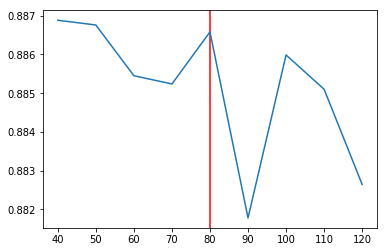

In [106]:
plt.xticks(list(range(12)), range(40, 130, 10))
plt.axvline(x=4, color='red')
plt.plot(p_history)

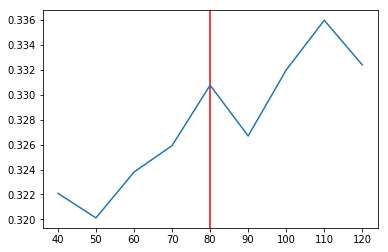

In [107]:
plt.xticks(list(range(12)), range(40, 130, 10))
plt.axvline(x=4, color='red')
plt.plot(r_history)

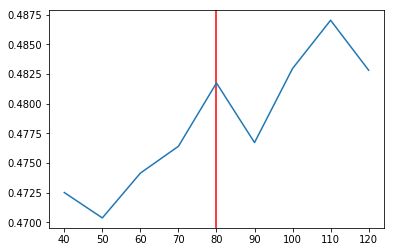

In [108]:
plt.xticks(list(range(12)), range(40, 130, 10))
plt.axvline(x=4, color='red')
plt.plot(f1_history)

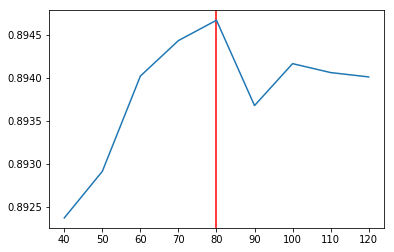

In [109]:
plt.xticks(list(range(12)), range(40, 130, 10))
plt.axvline(x=4, color='red')
plt.plot(ndcg_history)

## 결론

KNN with Means 알고리즘은 K가 80 일때 가장 좋은 성능을 내고, 

이후 K가 증가할 수록 Overfitting이 발생한다.